In [2]:
import os, sys
import random
import time

from pathlib import Path
import glob, json

import pandas as pd
import numpy as np
from collections import defaultdict

from pprint import pprint

import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import ast

import nltk
from nltk import tokenize
nltk.download('punkt')

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /Users/ytcao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ytcao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
initial_analysis_path = "./analysis.csv"

bar_col = {
    "DM-rambling": "blue",
    "DM-brief":"green",
    "SM-rambling": "yellow",
    "SM-brief":"red",
}

In [4]:
analysis_df = pd.read_csv(initial_analysis_path)
analysis_df.head()

,filename,is_double_model,patient_str,is_rambling_prompt,total_cost,time,edge_case,user_temp,asst_temp,temp,...,asst_utt,'asst_messages',asst_distinct1,'asst_msg_len',asst_avg_msg_len,user_utt,'user_messages',user_distinct1,'user_msg_len',user_avg_msg_len
0,DM_20240428-221529_Interview.json,True,Sex: Female\nName: Deborah Brittany Mclaughlin...,False,1.28494,165.563632,"Upon first asking about medication, please mis...",0.5,0.5,NaN,...,40,"Great, thank you for your cooperation. Let's s...",0.334919,122|70|41|31|63|83|64|38|100|67|94|68|165|148|...,128.425000,40,"Yeah, sure. Let's get this over with.|Deborah ...",0.363269,37|28|17|17|7|29|9|9|60|35|22|13|135|67|76|52|...,106.800000
1,DM_20240428-223120_Interview.json,True,Sex: Female\nName: Tina Amy Quinn\nAge: 40\nDa...,True,2.32413,300.651896,"Upon first asking about medication, please mis...",0.5,0.5,NaN,...,31,Thank you for being willing to share your info...,0.278351,194|107|145|189|146|312|294|460|319|372|216|42...,399.000000,31,"Hey there, yeah, sure, I guess talking a bit c...",0.187555,272|156|231|209|287|372|490|474|221|583|355|56...,626.354839
2,DM_20240428-220138_Interview.json,True,Sex: Male\nName: Sergio Aaron Dunn\nAge: 22\nD...,True,2.17653,257.611909,NaN,0.5,0.5,NaN,...,37,"Thank you for sharing that with me, and I'm tr...",0.286475,336|81|60|94|69|185|138|77|195|239|203|155|212...,264.189189,37,"Hey there,\n\nYeah, I guess chatting for a bit...",0.215073,1135|40|45|73|9|117|58|70|160|175|235|67|388|1...,396.189189
3,DM_20240428-222702_Interview.json,True,Sex: Male\nName: Jose John Anderson\nAge: 21\n...,True,2.22718,255.679965,"Upon first asking about medication, please mis...",0.5,0.5,NaN,...,38,I understand your concerns and appreciate your...,0.297778,174|111|58|92|76|135|103|205|288|234|129|175|1...,242.263158,38,"Hey, yeah, I guess it's fine. Don't really see...",0.197730,298|124|84|178|75|148|169|118|258|284|142|336|...,388.368421
4,DM_20240428-215539_Interview.json,True,Sex: Male\nName: Oscar Webb\nAge: 52\nDate of ...,True,2.85257,324.907880,NaN,0.5,0.5,NaN,...,42,"I appreciate your willingness to share, and I ...",0.282519,331|126|86|40|83|108|90|110|254|207|186|225|11...,270.476190,42,"Hey there, yeah, I guess I can spare a bit of ...",0.227835,381|88|108|91|16|103|107|131|334|360|239|418|8...,407.761905


create a labeled_df to group together creation methods and prompt types

In [6]:
def assign_dataset_label(analysis_df):
    return pd.concat(
        [analysis_df[analysis_df["is_double_model"]==True][analysis_df["is_rambling_prompt"]==True].assign(dataset="DM-rambling", bar_col=bar_col["DM-rambling"]), 
        analysis_df[analysis_df["is_double_model"]==True][analysis_df["is_rambling_prompt"]==False].assign(dataset="DM-brief", bar_col=bar_col["DM-brief"]),
        analysis_df[analysis_df["is_double_model"]==False][analysis_df["is_rambling_prompt"]==True].assign(dataset="SM-rambling", bar_col=bar_col["SM-rambling"]),
        analysis_df[analysis_df["is_double_model"]==False][analysis_df["is_rambling_prompt"]==False].assign(dataset="SM-brief", bar_col=bar_col["SM-brief"])])

def assign_dataset_label_gentype(analysis_df):
    return pd.concat(
        [analysis_df[analysis_df["is_double_model"]==True].assign(gentype="DM", bar_col=bar_col["DM-rambling"]), 
        analysis_df[analysis_df["is_double_model"]==False].assign(gentype="SM", bar_col=bar_col["SM-rambling"])])

In [5]:

def convert_pvalue_to_asterisks(pvalue, bf_correction):
    if pvalue <= 0.0001/bf_correction:
        return "****"
    elif pvalue <= 0.001/bf_correction:
        return "***"
    elif pvalue <= 0.01/bf_correction:
        return "**"
    elif pvalue <= 0.05/bf_correction:
        return "*"
    return "ns"

def get_role_comparison_pvalues(dfm, col, x_val="dataset", bf_correction = False):
    '''
    Parameters
    ----------
    dfm : pandas DataFrame 
        with columns "dataset" and "role" as either assistant/patient. values in the "x_val" column will be paired.
    col : str
        name of column in dfm that pvalue should be calculated from
    
    Output
    ------
    list
    '''
    x_values = dfm[x_val].unique()
    pvalues_list = []
    done = []
    for x in x_values:
        for x1 in x_values:
            if x != x1 and x1 not in done:
                asst_stat, asst_pvalue = scipy.stats.ttest_ind(
                    dfm[(dfm[x_val] == x) & (dfm["role"] == "assistant")][col],
                    dfm[(dfm[x_val] == x1) & (dfm["role"] == "assistant")][col]
                )
                user_stat, user_pvalue = scipy.stats.ttest_ind(
                    dfm[(dfm[x_val] == x) & (dfm["role"] == "patient")][col],
                    dfm[(dfm[x_val] == x1) & (dfm["role"] == "patient")][col]
                )
                pvalues_list.append(((x, x1), 
                                        {"assistant":(asst_pvalue), 
                                        "patient":(user_pvalue)}))
                
            done.append(x)
    if bf_correction:
        corr_val = len(done)
        pvalues_list = [((x, x1), 
                         {"assistant": (pvalue_dict["assistant"], 
                                        convert_pvalue_to_asterisks(pvalue_dict["assistant"], corr_val)),
                          "patient":  (pvalue_dict["patient"], 
                                       convert_pvalue_to_asterisks(pvalue_dict["patient"], corr_val))
                          }) for ((x, x1), pvalue_dict) in pvalues_list]
    else:
        pvalues_list = [((x, x1), 
                         {"assistant": (pvalue_dict["assistant"], 
                                        convert_pvalue_to_asterisks(pvalue_dict["assistant"], 1)),
                          "patient":  (pvalue_dict["patient"], 
                                       convert_pvalue_to_asterisks(pvalue_dict["patient"], 1))
                          }) for ((x, x1), pvalue_dict) in pvalues_list]
    return pvalues_list

def get_pvalues(dfm, col, x_val="dataset", bf_correction=False):
    '''
    Parameters
    ----------
    dfm : pandas DataFrame 
        with columns "dataset" and "speaker" as either assistant/patient. values in the "x_val" column will be paired.
    col : str
        name of column in dfm that pvalue should be calculated from
    x_val : str
        name of the column in dfm that is the x axis grouping
    bf_correction : bool
        whether or not bonferroni correction is applied
    '''
    x_values = dfm[x_val].unique()
    pvalues_list = []
    done = []
    for x in x_values:
        for x1 in x_values:
            if x != x1 and x1 not in done:
                stat, pvalue = scipy.stats.ttest_ind(
                    dfm[dfm[x_val] == x][col],
                    dfm[dfm[x_val] == x1][col]
                )
                pvalues_list.append(((x, x1), pvalue))
            done.append(x)

    #add asterisks for significance
    if bf_correction:
        corr_val = len(done)
        pvalues_list = [((x, x1), pvalue, convert_pvalue_to_asterisks(pvalue, corr_val)) for ((x, x1), pvalue) in pvalues_list]
    else:
        pvalues_list = [((x, x1), pvalue, convert_pvalue_to_asterisks(pvalue, 1)) for ((x, x1), pvalue) in pvalues_list]
    return pvalues_list

In [100]:
def barplot_data(df, x_axis:str, y_axis:str, x_axis_label="", y_axis_label="", palette = sns.color_palette('Paired',4)):
    g = sns.barplot(
        data=df, 
        x=x_axis, y=y_axis, 
        hue=x_axis,
        palette = palette,
        errorbar="sd", alpha=.6
    )

    if x_axis_label=="":
            x_axis_label = x_axis
    if y_axis_label=="":
        y_axis_label = y_axis
    g.set(xlabel=x_axis_label, ylabel=y_axis_label)

    g = sns.swarmplot(x=x_axis, y=y_axis, hue=x_axis,
    # palette="dark", 
    linewidth=1, edgecolor="black",
    palette = palette,
    alpha=.5, dodge=True,data=df)
    
    return g

def barplot_grouped_data(melted_df, x_axis:str, y_axis:str, x_axis_groupings:str, x_axis_label="", y_axis_label="", legend_label="", palette = sns.color_palette('Paired',4), legend_under=False):
    '''Create a bar plot with error bars.

    x_axis="speaker"
    y_axis="avg_msg_len"
    x_axis_groupings="dataset"
    
    x_axis_label="Transcript Creation Method"
    y_axis_label="Avg Message Length (characters)"
    legend_label="Role"
    '''
    #make bar graph
    #optionally add palette="dark"
    g = sns.catplot(
        data=melted_df, kind="bar",
        x=x_axis, y=y_axis, hue=x_axis_groupings,
        errorbar="sd", 
        # color=bar_col, ##not working
        # palette="dark",
        palette = palette,
        alpha=.6, height=6,
        legend=False
    )
    g.despine(left=True)

    if x_axis_label=="":
            x_axis_label = x_axis
    if y_axis_label=="":
        y_axis_label = y_axis
    g.set_axis_labels(x_axis_label, y_axis_label)

    #add individual points, must come after label attaching
    g = sns.swarmplot(x=x_axis, y=y_axis, hue=x_axis_groupings,
    # palette="dark", 
    palette = palette,
    linewidth=1, edgecolor="black",
    alpha=.5, dodge=True,data=melted_df)

    #create legend
    if legend_label=="" and x_axis==x_axis_groupings:
        pass
    elif legend_label=="":
        legend_label = x_axis_groupings
        if legend_under:
            plt.legend(title=legend_label, loc = "lower center", bbox_to_anchor=(.5, -0.2), ncol=4)
        else:
            plt.legend(title=legend_label,loc='upper left',bbox_to_anchor=(1, 1))
        

        # g.legend.set_title(legend_label)
    else:
        if legend_under:
            plt.legend(title=legend_label, loc = "lower center", bbox_to_anchor=(.5, -0.2), ncol=4)
        else:
            plt.legend(title=legend_label,loc='upper left',bbox_to_anchor=(1, 1))
         
        # g.legend.set_title(legend_label)
    # plt.legend([],[], frameon=False)
    
    return g

In [8]:
def get_melted_df(labeled_df, vars_to_keep:list, vars_to_melt, melted_name_col:str, melted_value_col:str):
    '''If the df has multiple columns "vars_to_melt", those column names will be shifted into a new column "melted_name_col" and their values will be shifted to a new column "melted_value_col".
    :param pandas dataframe labeled_df:
    :param list vars_to_keep:
    :param vars_to_melt: keys of the variables to melt together, values being the replacement for those variables
    :type vars_to_melt: list, dict
    :param str melted_name_col:
    :param str melted_value_col:

    labeled_df=labeled_df
    vars_to_keep=["dataset","bar_col"]
    vars_to_melt={"asst_avg_msg_len": "assistant", "user_avg_msg_len": "patient"}
    melted_name_col="speaker"
    melted_value_col="avg_msg_len"
    '''
    if type(vars_to_melt) == dict:
        vars_to_melt_list = [k for k in vars_to_melt.keys()]
        print(vars_to_melt_list)
        labeled_dfm = pd.melt(labeled_df, 
                            id_vars=vars_to_keep, 
                            value_vars=vars_to_melt_list, 
                            var_name=melted_name_col, 
                            value_name=melted_value_col) 
        #rename if available
        for var in vars_to_melt_list:
            labeled_dfm = labeled_dfm.replace(var, vars_to_melt[var])
    elif type(vars_to_melt) == list:
        labeled_dfm = pd.melt(labeled_df, 
                            id_vars=vars_to_keep, 
                            value_vars=vars_to_melt, 
                            var_name=melted_name_col, 
                            value_name=melted_value_col) 
    return labeled_dfm

In [9]:
def avg_these_variables(df, var_list, df_dataset_vars = ['DM-rambling', 'DM-brief', 'SM-rambling','SM-brief']):
    '''given a list of columns var_list present in DataFrame df, return the average of those columns. df should have a column named "dataset" of values in list df_dataset.'''
    def find_avg_across_col(df, dataset, col):
        '''given dataframe df with columns "dataset" and col, calculates the average down the column col for the matching "dataset" rows. elements in the column df[col] should be numeric.'''
        return np.average(
            df[df['dataset']==dataset][col])

    data_dict = defaultdict(list)
    data_dict["index"] = df_dataset_vars

    for dataset in data_dict["index"]:
        for var in var_list:
            data_dict[var].append(
                find_avg_across_col(df, dataset, var)
                )
    return data_dict

def describe_these_variables(df, var_list, dataset_col = "dataset"):
    '''given a list of columns var_list present in DataFrame df, return the description based on the column dataset_col.'''
    df_dataset_vars = df[dataset_col].unique() #['DM-rambling', 'DM-brief', 'SM-rambling','SM-brief']
    data_dict = {}
    for var in var_list:
        if df[var].dtype.name=="category":
            for dataset in df_dataset_vars:
                # print(f"var: {var}, dataset: {dataset}")
                data_dict[f"{var}_{dataset}"] = df[df[dataset_col]==dataset][var].value_counts().T.to_dict()
                # data_df[f"{var}_{dataset}"] = df[df[var]==dataset].describe()
        else:
            for dataset in df_dataset_vars:
                # print(f"var: {var}, dataset: {dataset}")
                data_dict[f"{var}_{dataset}"] = df[df[dataset_col]==dataset][var].describe().T.to_dict()
                # data_df[f"{var}_{dataset}"] = df[df[var]==dataset].describe()

    data_df = pd.DataFrame(data_dict)
    return data_df

In [10]:
labeled_df = assign_dataset_label(analysis_df)

/var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/ipykernel_67470/562856978.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  [analysis_df[analysis_df["is_double_model"]==True][analysis_df["is_rambling_prompt"]==True].assign(dataset="DM-rambling", bar_col=bar_col["DM-rambling"]),
/var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/ipykernel_67470/562856978.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  analysis_df[analysis_df["is_double_model"]==True][analysis_df["is_rambling_prompt"]==False].assign(dataset="DM-brief", bar_col=bar_col["DM-brief"]),
/var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/ipykernel_67470/562856978.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  analysis_df[analysis_df["is_double_model"]==False][analysis_df["is_rambling_prompt"]==True].assign(dataset="SM-rambling", bar_col=bar_col["SM-rambling"]),
/var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/ipykernel_67470

# initial analysis

### average message length of each role depending on the transcript creation method

In [11]:
avg_message_len_df = get_melted_df(
    labeled_df, 
    vars_to_keep=["dataset","bar_col"], 
    vars_to_melt={
        "asst_avg_msg_len": "assistant", 
        "user_avg_msg_len": "patient"
        }, 
    melted_name_col="role", 
    melted_value_col="avg_msg_len")

['asst_avg_msg_len', 'user_avg_msg_len']


In [12]:
describe_these_variables(avg_message_len_df[avg_message_len_df["role"]=="assistant"],["avg_msg_len"])

,avg_msg_len_DM-rambling,avg_msg_len_DM-brief,avg_msg_len_SM-rambling,avg_msg_len_SM-brief
count,5.000000,5.000000,5.000000,5.000000
mean,275.810708,151.945341,141.615278,102.691147
std,73.735624,14.200676,36.003925,15.719793
min,203.125000,128.425000,102.000000,93.250000
25%,242.263158,152.105263,120.888889,93.678571
50%,264.189189,153.513514,126.750000,95.421053
75%,270.476190,160.243902,170.937500,100.815789
max,399.000000,165.439024,187.500000,130.290323


In [13]:
describe_these_variables(avg_message_len_df[avg_message_len_df["role"]=="patient"],["avg_msg_len"])

,avg_msg_len_DM-rambling,avg_msg_len_DM-brief,avg_msg_len_SM-rambling,avg_msg_len_SM-brief
count,5.000000,5.000000,5.000000,5.000000
mean,447.859871,103.218603,95.508709,48.263711
std,100.522548,9.664556,27.266028,17.253148
min,388.368421,91.219512,65.312500,29.689655
25%,396.189189,95.195122,74.857143,40.230769
50%,407.761905,106.800000,100.894737,46.605263
75%,420.625000,108.500000,101.312500,48.631579
max,626.354839,114.378378,135.166667,76.161290


Text(0.5, 1.0, 'Average Message Length per Role')

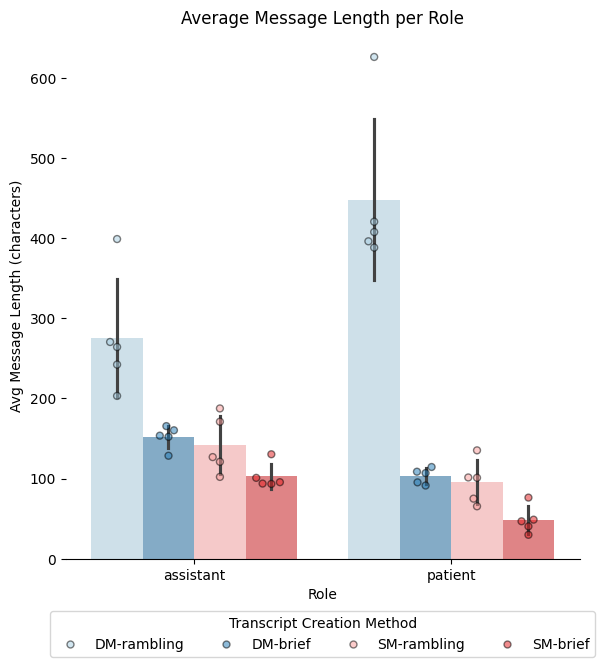

In [98]:
g = barplot_grouped_data(avg_message_len_df, x_axis="role", y_axis="avg_msg_len",x_axis_groupings="dataset", x_axis_label="Role", y_axis_label="Avg Message Length (characters)", legend_label="Transcript Creation Method", palette = [sns.color_palette('Paired',6)[0], sns.color_palette('Paired',6)[1], sns.color_palette('Paired',6)[4], sns.color_palette('Paired',6)[5]])
plt.title("Average Message Length per Role")

In [73]:
avg_msg_len_pvalues_bfcorr = get_role_comparison_pvalues(avg_message_len_df, "avg_msg_len", bf_correction=True) 
avg_msg_len_pvalues_bfcorr

[(('DM-rambling', 'DM-brief'),
  {'assistant': (0.0061435023456160335, 'ns'),
   'patient': (6.123771525227829e-05, '***')}),
 (('DM-rambling', 'SM-rambling'),
  {'assistant': (0.006430086072345894, 'ns'),
   'patient': (6.518501904292355e-05, '**')}),
 (('DM-rambling', 'SM-brief'),
  {'assistant': (0.0008910885534456116, '*'),
   'patient': (2.2581870543588814e-05, '***')}),
 (('DM-brief', 'SM-rambling'),
  {'assistant': (0.5671321022731097, 'ns'),
   'patient': (0.5676807844488132, 'ns')}),
 (('DM-brief', 'SM-brief'),
  {'assistant': (0.0008234552175347062, '*'),
   'patient': (0.00025554263964552826, '**')}),
 (('SM-rambling', 'SM-brief'),
  {'assistant': (0.05758778462923174, 'ns'),
   'patient': (0.011286703851902223, 'ns')})]

### conversational rounds by creation method

In [108]:
describe_these_variables(labeled_df, ["convo_rounds"])

,convo_rounds_DM-rambling,convo_rounds_DM-brief,convo_rounds_SM-rambling,convo_rounds_SM-brief
count,5.000000,5.00000,5.000000,5.000000
mean,37.600000,39.40000,23.900000,29.600000
std,4.159327,1.81659,8.876936,10.448684
min,31.000000,37.00000,16.000000,12.500000
25%,37.000000,38.00000,18.000000,28.500000
50%,38.000000,40.00000,18.500000,31.000000
75%,40.000000,41.00000,32.000000,38.000000
max,42.000000,41.00000,35.000000,38.000000


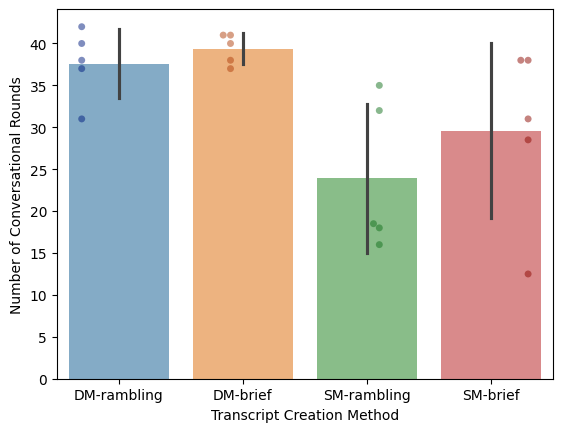

In [186]:
g = barplot_data(labeled_df, x_axis="dataset", y_axis="convo_rounds", y_axis_label="Number of Conversational Rounds", x_axis_label="Transcript Creation Method")

In [67]:
convo_rounds_bfcorr = get_pvalues(labeled_df, "convo_rounds", bf_correction=True) 
convo_rounds_bfcorr

[(('DM-rambling', 'DM-brief'), 0.40106059068761357, 'ns'),
 (('DM-rambling', 'SM-rambling'), 0.014122505811683178, 'ns'),
 (('DM-rambling', 'SM-brief'), 0.15035415191343862, 'ns'),
 (('DM-brief', 'SM-rambling'), 0.005052817488622598, 'ns'),
 (('DM-brief', 'SM-brief'), 0.07265105446311301, 'ns'),
 (('SM-rambling', 'SM-brief'), 0.37975939437837647, 'ns')]

### distinct-1 scores by each role depending on transcript creation method

In [24]:
labeled_df.head()

,filename,is_double_model,patient_str,is_rambling_prompt,total_cost,time,edge_case,user_temp,asst_temp,temp,...,asst_distinct1,'asst_msg_len',asst_avg_msg_len,user_utt,'user_messages',user_distinct1,'user_msg_len',user_avg_msg_len,dataset,bar_col
1,DM_20240428-223120_Interview.json,True,Sex: Female\nName: Tina Amy Quinn\nAge: 40\nDa...,True,2.32413,300.651896,"Upon first asking about medication, please mis...",0.5,0.5,NaN,...,0.278351,194|107|145|189|146|312|294|460|319|372|216|42...,399.000000,31,"Hey there, yeah, sure, I guess talking a bit c...",0.187555,272|156|231|209|287|372|490|474|221|583|355|56...,626.354839,DM-rambling,blue
2,DM_20240428-220138_Interview.json,True,Sex: Male\nName: Sergio Aaron Dunn\nAge: 22\nD...,True,2.17653,257.611909,NaN,0.5,0.5,NaN,...,0.286475,336|81|60|94|69|185|138|77|195|239|203|155|212...,264.189189,37,"Hey there,\n\nYeah, I guess chatting for a bit...",0.215073,1135|40|45|73|9|117|58|70|160|175|235|67|388|1...,396.189189,DM-rambling,blue
3,DM_20240428-222702_Interview.json,True,Sex: Male\nName: Jose John Anderson\nAge: 21\n...,True,2.22718,255.679965,"Upon first asking about medication, please mis...",0.5,0.5,NaN,...,0.297778,174|111|58|92|76|135|103|205|288|234|129|175|1...,242.263158,38,"Hey, yeah, I guess it's fine. Don't really see...",0.197730,298|124|84|178|75|148|169|118|258|284|142|336|...,388.368421,DM-rambling,blue
4,DM_20240428-215539_Interview.json,True,Sex: Male\nName: Oscar Webb\nAge: 52\nDate of ...,True,2.85257,324.907880,NaN,0.5,0.5,NaN,...,0.282519,331|126|86|40|83|108|90|110|254|207|186|225|11...,270.476190,42,"Hey there, yeah, I guess I can spare a bit of ...",0.227835,381|88|108|91|16|103|107|131|334|360|239|418|8...,407.761905,DM-rambling,blue
5,DM_20240428-221850_Interview.json,True,Sex: Female\nName: Rebecca Jillian Smith\nAge:...,True,2.43375,279.346132,"Upon first asking about medication, please mis...",0.5,0.5,NaN,...,0.294671,125|90|67|79|79|143|81|88|78|114|143|145|94|14...,203.125000,40,"Oh, hello there. Yeah, sure, I guess we can ta...",0.187110,263|103|95|170|72|167|155|187|217|206|254|101|...,420.625000,DM-rambling,blue


In [25]:
distinct1_df = get_melted_df(
    labeled_df, 
    vars_to_keep=["dataset","bar_col"], 
    vars_to_melt={
        "asst_distinct1": "assistant", 
        "user_distinct1": "patient"
        }, 
    melted_name_col="role", 
    melted_value_col="distinct1")
describe_these_variables(distinct1_df[distinct1_df["role"]=="assistant"], ["distinct1"])

['asst_distinct1', 'user_distinct1']


,distinct1_DM-rambling,distinct1_DM-brief,distinct1_SM-rambling,distinct1_SM-brief
count,5.000000,5.000000,5.000000,5.000000
mean,0.287959,0.308299,0.360970,0.379467
std,0.008148,0.018256,0.021038,0.033385
min,0.278351,0.289691,0.331340,0.355731
25%,0.282519,0.292808,0.347594,0.362356
50%,0.286475,0.309767,0.368497,0.364299
75%,0.294671,0.314310,0.375000,0.377451
max,0.297778,0.334919,0.382418,0.437500


In [26]:
describe_these_variables(distinct1_df[distinct1_df["role"]=="patient"], ["distinct1"])

,distinct1_DM-rambling,distinct1_DM-brief,distinct1_SM-rambling,distinct1_SM-brief
count,5.000000,5.000000,5.000000,5.000000
mean,0.203061,0.356550,0.409475,0.479860
std,0.017898,0.009058,0.024066,0.082860
min,0.187110,0.342391,0.378539,0.406181
25%,0.187555,0.352880,0.399334,0.419414
50%,0.197730,0.360184,0.401942,0.451685
75%,0.215073,0.363269,0.430730,0.514019
max,0.227835,0.364026,0.436831,0.608000


Text(0.5, 1.0, 'Distinct-1 Score per Role')

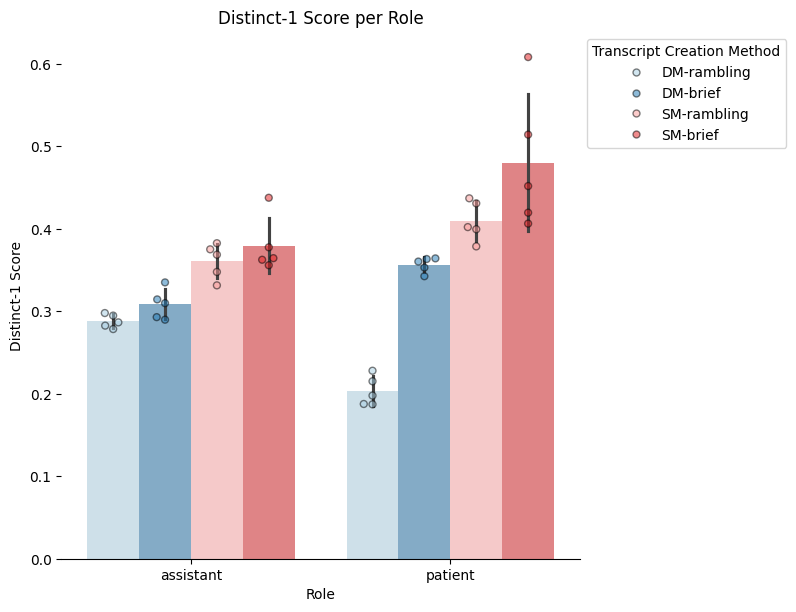

In [101]:
g = barplot_grouped_data(distinct1_df, x_axis="role", y_axis="distinct1",x_axis_groupings="dataset", x_axis_label="Role", y_axis_label="Distinct-1 Score", legend_label="Transcript Creation Method", palette = [sns.color_palette('Paired',6)[0], sns.color_palette('Paired',6)[1], sns.color_palette('Paired',6)[4], sns.color_palette('Paired',6)[5]],legend_under=False)
plt.title("Distinct-1 Score per Role")

In [82]:
distinct1_bfcorr = get_role_comparison_pvalues(
    distinct1_df, 
    col="distinct1", 
    bf_correction=True) 
distinct1_bfcorr

[(('DM-rambling', 'DM-brief'),
  {'assistant': (0.052474518659042825, 'ns'),
   'patient': (1.383887086513482e-07, '****')}),
 (('DM-rambling', 'SM-rambling'),
  {'assistant': (8.92315456044236e-05, '**'),
   'patient': (3.1585980996797874e-07, '****')}),
 (('DM-rambling', 'SM-brief'),
  {'assistant': (0.00034031019277979405, '**'),
   'patient': (8.377592465443244e-05, '**')}),
 (('DM-brief', 'SM-rambling'),
  {'assistant': (0.0028833939371859336, '*'),
   'patient': (0.00175021323128607, '*')}),
 (('DM-brief', 'SM-brief'),
  {'assistant': (0.0030699648427962288, '*'),
   'patient': (0.01073074551971893, 'ns')}),
 (('SM-rambling', 'SM-brief'),
  {'assistant': (0.32518109322162303, 'ns'),
   'patient': (0.10559805533903847, 'ns')})]

# graphing GPT-generated analysis

In [28]:
gpt_analysis_path = "./gpt_analysis.csv"
gpt_df = pd.read_csv(gpt_analysis_path)
gpt_df.describe()

,total_cost,time,user_temp,asst_temp,temp,convo_length,convo_rounds,asst_utt,asst_distinct1,asst_avg_msg_len,...,asst_avg_qs_per_msg,asst_num_sentences,asst_num_qs,asst_opening_qs,asst_indepth_qs,asst_empathy_statements,asst_other_statements,asst_coverage,user_coverage,analysis_cost
count,20.000000,20.000000,10.0,10.0,10.0,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.950911,122.201654,0.5,0.5,0.5,65.250000,32.625000,32.550000,0.334174,168.015618,...,1.318284,32.550000,41.250000,17.750000,23.500000,36.550000,13.200000,78.450000,79.350000,0.531071
std,1.027232,114.348193,0.0,0.0,0.0,18.433022,9.216511,9.327238,0.043348,77.098529,...,0.155138,9.327238,14.078259,5.504783,9.116209,17.412866,5.925858,23.959341,28.844912,0.301092
min,0.010870,1.011086,0.5,0.5,0.5,25.000000,12.500000,12.000000,0.278351,93.250000,...,1.066667,12.000000,16.000000,7.000000,7.000000,6.000000,3.000000,30.000000,0.000000,0.174050
25%,0.034047,22.283351,0.5,0.5,0.5,60.750000,30.375000,30.250000,0.294205,116.166667,...,1.198387,30.250000,32.750000,13.000000,20.500000,27.000000,8.000000,68.750000,83.250000,0.269572
50%,0.671385,99.725049,0.5,0.5,0.5,74.000000,37.000000,37.000000,0.333129,152.809388,...,1.304899,37.000000,42.000000,19.000000,23.500000,36.000000,12.500000,88.500000,92.000000,0.456720
75%,1.611367,192.868198,0.5,0.5,0.5,77.000000,38.500000,38.500000,0.365348,191.406250,...,1.446951,38.500000,51.000000,20.500000,30.250000,45.750000,19.000000,98.000000,93.500000,0.718448
max,2.852570,324.907880,0.5,0.5,0.5,84.000000,42.000000,42.000000,0.437500,399.000000,...,1.611111,42.000000,62.000000,28.000000,40.000000,72.000000,25.000000,100.000000,98.000000,1.086900


In [29]:
gpt_df.keys()

Index(['filename', 'is_double_model', 'patient_str', 'is_rambling_prompt',
       'total_cost', 'time', 'edge_case', 'user_temp', 'asst_temp', 'temp',
       'convo_length', 'convo_rounds', 'asst_utt', ''asst_messages'',
       'asst_distinct1', ''asst_msg_len'', 'asst_avg_msg_len', 'user_utt',
       ''user_messages'', 'user_distinct1', ''user_msg_len'',
       'user_avg_msg_len', ''asst_category_per_msg'', ''asst_qs_per_msg'',
       'asst_avg_qs_per_msg', ''asst_sentences_dict'', ''asst_category_list'',
       ''asst_qs_list'', 'asst_num_sentences', 'asst_num_qs',
       'asst_opening_qs', 'asst_indepth_qs', 'asst_empathy_statements',
       'asst_other_statements', 'asst_coverage', ''asst_coverage_content'',
       ''user_summary'', 'user_coverage', ''user_coverage_content'',
       'analysis_cost', ''user_edge_case_present'',
       ''asst_edge_case_present''],
      dtype='object')

In [30]:
gpt_ldf = assign_dataset_label(gpt_df) #get "dataset" column
gpt_ldf = assign_dataset_label_gentype(gpt_ldf) #get "gen-type" column

/var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/ipykernel_67470/562856978.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  [analysis_df[analysis_df["is_double_model"]==True][analysis_df["is_rambling_prompt"]==True].assign(dataset="DM-rambling", bar_col=bar_col["DM-rambling"]),
/var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/ipykernel_67470/562856978.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  analysis_df[analysis_df["is_double_model"]==True][analysis_df["is_rambling_prompt"]==False].assign(dataset="DM-brief", bar_col=bar_col["DM-brief"]),
/var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/ipykernel_67470/562856978.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  analysis_df[analysis_df["is_double_model"]==False][analysis_df["is_rambling_prompt"]==True].assign(dataset="SM-rambling", bar_col=bar_col["SM-rambling"]),
/var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/ipykernel_67470

### coverage score

In [31]:
df_coverage = get_melted_df(gpt_ldf, ["filename","dataset", "bar_col"], {"asst_coverage":"assistant", "user_coverage":"patient"}, "role", "coverage")

['asst_coverage', 'user_coverage']


Text(0.5, 1.0, 'Coverage Score per Role')

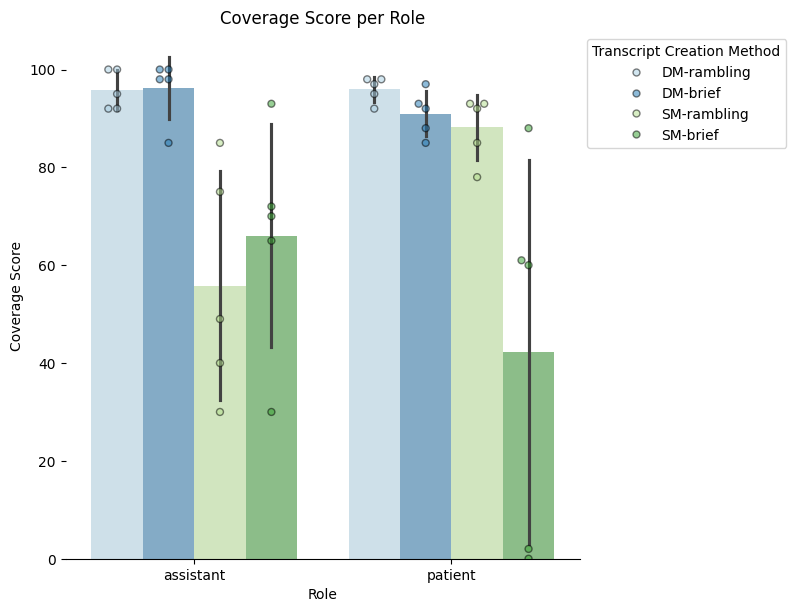

In [32]:
g = barplot_grouped_data(df_coverage, x_axis="role", y_axis="coverage",x_axis_groupings="dataset", x_axis_label="Role", y_axis_label="Coverage Score", legend_label="Transcript Creation Method")
plt.title("Coverage Score per Role")

In [33]:
describe_these_variables(df_coverage[df_coverage["role"]=="assistant"], ["coverage"])

,coverage_DM-rambling,coverage_DM-brief,coverage_SM-rambling,coverage_SM-brief
count,5.000000,5.000000,5.000000,5.000000
mean,95.800000,96.200000,55.800000,66.000000
std,4.024922,6.340347,23.360223,22.792543
min,92.000000,85.000000,30.000000,30.000000
25%,92.000000,98.000000,40.000000,65.000000
50%,95.000000,98.000000,49.000000,70.000000
75%,100.000000,100.000000,75.000000,72.000000
max,100.000000,100.000000,85.000000,93.000000


In [34]:
describe_these_variables(df_coverage[df_coverage["role"]=="patient"], ["coverage"])

,coverage_DM-rambling,coverage_DM-brief,coverage_SM-rambling,coverage_SM-brief
count,5.00000,5.000000,5.000000,5.00000
mean,96.00000,91.000000,88.200000,42.20000
std,2.54951,4.636809,6.610598,39.25812
min,92.00000,85.000000,78.000000,0.00000
25%,95.00000,88.000000,85.000000,2.00000
50%,97.00000,92.000000,92.000000,60.00000
75%,98.00000,93.000000,93.000000,61.00000
max,98.00000,97.000000,93.000000,88.00000


In [35]:
get_role_comparison_pvalues(
    df_coverage, 
    col="coverage", 
    bf_correction=True) 
# get_comparison_pvalues(
#     df_coverage, 
#     col="coverage", 
#     bf_correction=True) 

[(('DM-rambling', 'DM-brief'),
  {'assistant': (0.9081338932931222, 'ns'),
   'patient': (0.06756921595310342, 'ns')}),
 (('DM-rambling', 'SM-rambling'),
  {'assistant': (0.005440335123363966, 'ns'),
   'patient': (0.03921722745592862, 'ns')}),
 (('DM-rambling', 'SM-brief'),
  {'assistant': (0.020543305597253213, 'ns'),
   'patient': (0.01563225500415378, 'ns')}),
 (('DM-brief', 'SM-rambling'),
  {'assistant': (0.005770244409652414, 'ns'),
   'patient': (0.46041399574272535, 'ns')}),
 (('DM-brief', 'SM-brief'),
  {'assistant': (0.021334367775956445, 'ns'),
   'patient': (0.02466074463362956, 'ns')}),
 (('SM-rambling', 'SM-brief'),
  {'assistant': (0.5044656902137432, 'ns'),
   'patient': (0.032429256461788764, 'ns')})]

In [36]:
df_coverage2 = get_melted_df(gpt_ldf, ["filename","gentype", "bar_col"], {"asst_coverage":"assistant", "user_coverage":"patient"}, "role", "coverage")

['asst_coverage', 'user_coverage']


Text(0.5, 1.0, 'Coverage Score per Role')

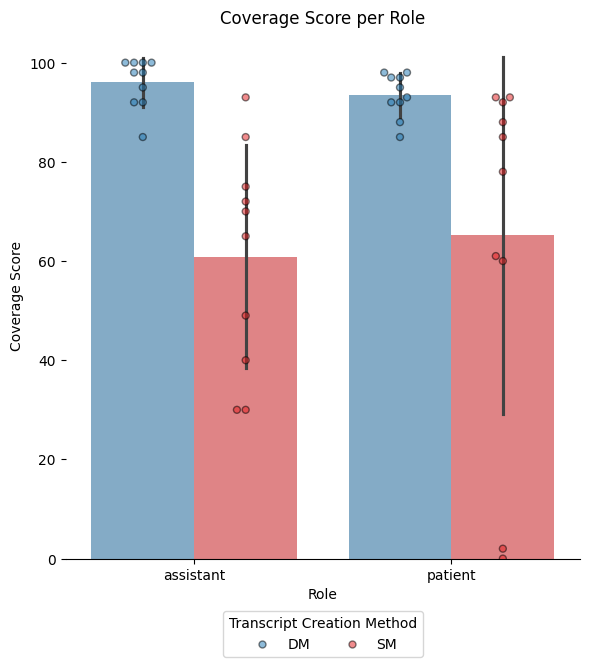

In [104]:
g = barplot_grouped_data(df_coverage2, x_axis="role", y_axis="coverage",x_axis_groupings="gentype", x_axis_label="Role", y_axis_label="Coverage Score", legend_label="Transcript Creation Method", palette = [sns.color_palette('Paired',6)[1], sns.color_palette('Paired',6)[5]], legend_under=True)
plt.title("Coverage Score per Role")

In [92]:
describe_these_variables(df_coverage2[df_coverage2["role"]=="patient"], ["coverage"], "gentype")

,coverage_DM,coverage_SM
count,10.000000,10.000000
mean,93.500000,65.200000
std,4.403282,35.946874
min,85.000000,0.000000
25%,92.000000,60.250000
50%,94.000000,81.500000
75%,97.000000,91.000000
max,98.000000,93.000000


In [93]:
describe_these_variables(df_coverage2[df_coverage2["role"]=="assistant"], ["coverage"], "gentype")

,coverage_DM,coverage_SM
count,10.000000,10.000000
mean,96.000000,60.900000
std,5.011099,22.412546
min,85.000000,30.000000
25%,92.750000,42.250000
50%,98.000000,67.500000
75%,100.000000,74.250000
max,100.000000,93.000000


In [331]:
get_role_comparison_pvalues(
    df_coverage2, 
    col="coverage", 
    x_val="gentype",
    bf_correction=True) 

[(('DM', 'SM'),
  {'assistant': (0.00013341747018727257, '***'),
   'patient': (0.023686440063543843, 'ns')})]

### QB initial in-depth ratio

In [86]:
question_bank = Path("../transcript_generation/prompts/questionbank_v2.txt").read_text()
qb_list = question_bank.split("\n")[:-1] #remove last question in qb_list, which is a command to end interview

filtered_qb_list = [q for q in qb_list if len(q) > 0 and q[0] != "#"]
qb_num_opening_qs = len([q for q in filtered_qb_list if len(q) > 0 and q[0] == "-"])
print("number of opening questions in question bank:", qb_num_opening_qs)
qb_num_idqs = len([q for q in filtered_qb_list if len(q) > 0 and q[0] == "+"])
print("number of in-depth questions in question bank:", qb_num_idqs)
# print(filtered_qb_list)
print("number of questions in question bank:", len(filtered_qb_list))

number of opening questions in question bank: 37
number of in-depth questions in question bank: 13
number of questions in question bank: 50


### num in-depth questions

In [333]:
gpt_ldf['num_questions_scaled'] = gpt_ldf['asst_indepth_qs']/gpt_ldf['asst_num_qs']
# 'asst_num_qs',
# 'asst_opening_qs'
# 'asst_indepth_qs'

Text(0.5, 1.0, 'Assistant In-Depth Ratio by Transcript Creation Method')

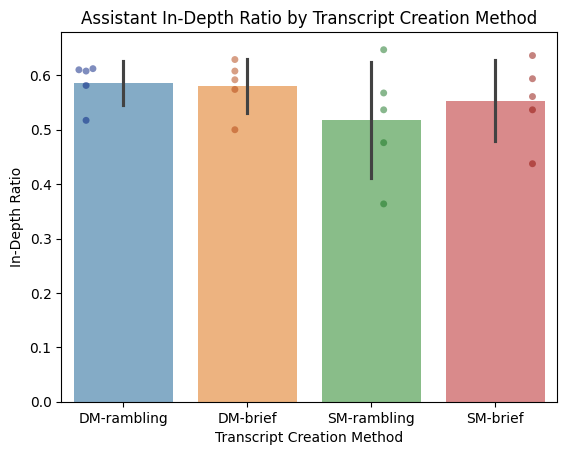

In [179]:
g = barplot_data(gpt_ldf, x_axis="dataset", y_axis="num_questions_scaled", x_axis_label="Transcript Creation Method", y_axis_label="In-Depth Ratio")
plt.title("Assistant In-Depth Ratio by Transcript Creation Method")

In [178]:
describe_these_variables(gpt_ldf, ['num_questions_scaled'])

,num_questions_scaled_DM-rambling,num_questions_scaled_DM-brief,num_questions_scaled_SM-rambling,num_questions_scaled_SM-brief
count,5.000000,5.000000,5.000000,5.000000
mean,0.585779,0.580557,0.518208,0.553035
std,0.040308,0.049379,0.106107,0.074638
min,0.517241,0.500000,0.363636,0.437500
25%,0.581395,0.574074,0.476190,0.536585
50%,0.607843,0.591837,0.536585,0.560976
75%,0.610169,0.607843,0.567568,0.593750
max,0.612245,0.629032,0.647059,0.636364


In [180]:
get_pvalues(
    gpt_ldf, 
    col="num_questions_scaled", 
    bf_correction=True) 

[(('DM-rambling', 'DM-brief'), 0.8592174082835566, 'ns'),
 (('DM-rambling', 'SM-rambling'), 0.21981863024974896, 'ns'),
 (('DM-rambling', 'SM-brief'), 0.41318426837744404, 'ns'),
 (('DM-brief', 'SM-rambling'), 0.26769217318219934, 'ns'),
 (('DM-brief', 'SM-brief'), 0.5111040651896753, 'ns'),
 (('SM-rambling', 'SM-brief'), 0.5649196179482612, 'ns')]

Text(0.5, 1.0, 'Assistant In-Depth Ratio by Transcript Creation Method')

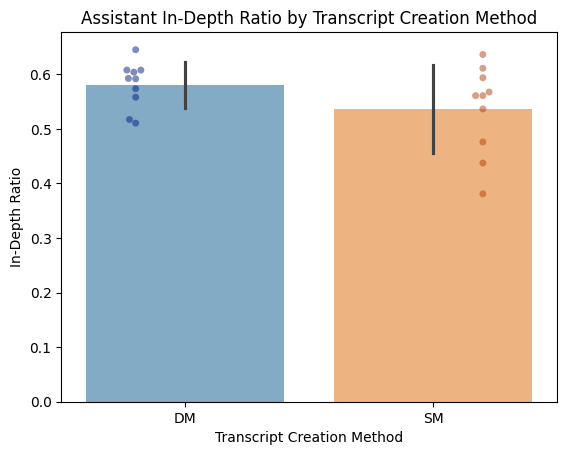

In [335]:
g = barplot_data(gpt_ldf, x_axis="gentype", y_axis="num_questions_scaled", x_axis_label="Transcript Creation Method", y_axis_label="In-Depth Ratio")
plt.title("Assistant In-Depth Ratio by Transcript Creation Method")

In [334]:
describe_these_variables(gpt_ldf, ['num_questions_scaled'], "gentype")

,num_questions_scaled_DM,num_questions_scaled_SM
count,10.000000,10.000000
mean,0.580923,0.536197
std,0.042081,0.080700
min,0.510638,0.380952
25%,0.562047,0.491289
50%,0.592215,0.560976
75%,0.606924,0.587204
max,0.645161,0.636364


In [336]:
get_pvalues(
    gpt_ldf, 
    col="num_questions_scaled", 
    x_val="gentype",
    bf_correction=True) 

[(('DM', 'SM'), 0.13758331334847687, 'ns')]

### avg num questions per assistant message

Text(0.5, 1.0, 'Assistant Average Questions per Message by Transcript Creation Method')

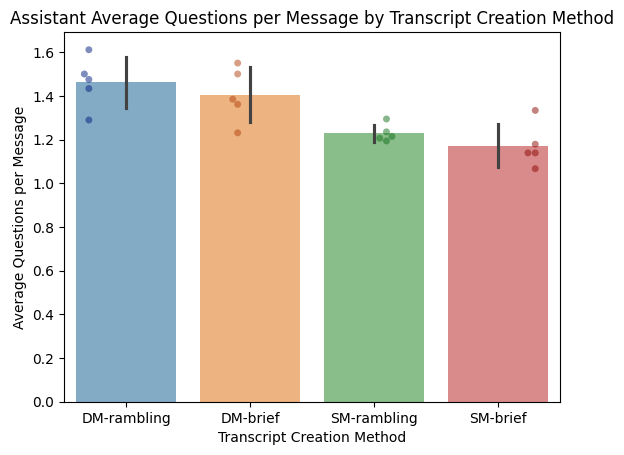

In [129]:
g = barplot_data(gpt_ldf, x_axis="dataset", y_axis='asst_avg_qs_per_msg', x_axis_label="Transcript Creation Method", y_axis_label="Average Questions per Message")
plt.title("Assistant Average Questions per Message by Transcript Creation Method")

In [127]:
describe_these_variables(gpt_ldf, ['asst_avg_qs_per_msg'])

,asst_avg_qs_per_msg_DM-rambling,asst_avg_qs_per_msg_DM-brief,asst_avg_qs_per_msg_SM-rambling,asst_avg_qs_per_msg_SM-brief
count,5.000000,5.000000,5.000000,5.000000
mean,1.461784,1.405299,1.228626,1.171270
std,0.116655,0.125247,0.039645,0.099193
min,1.289474,1.230769,1.193548,1.066667
25%,1.433333,1.361111,1.205882,1.138889
50%,1.475000,1.384615,1.214286,1.138889
75%,1.500000,1.500000,1.235294,1.178571
max,1.611111,1.550000,1.294118,1.333333


In [181]:
get_pvalues(
    gpt_ldf, 
    col="asst_avg_qs_per_msg", 
    bf_correction=True) 

[(('DM-rambling', 'DM-brief'), 0.48164034395669386, 'ns'),
 (('DM-rambling', 'SM-rambling'), 0.0028704299453502133, '*'),
 (('DM-rambling', 'SM-brief'), 0.0028285964351335994, '*'),
 (('DM-brief', 'SM-rambling'), 0.016887101641963928, 'ns'),
 (('DM-brief', 'SM-brief'), 0.011265128916528656, 'ns'),
 (('SM-rambling', 'SM-brief'), 0.264243390878871, 'ns')]

Text(0.5, 1.0, 'Assistant Average Questions per Message by Transcript Creation Method')

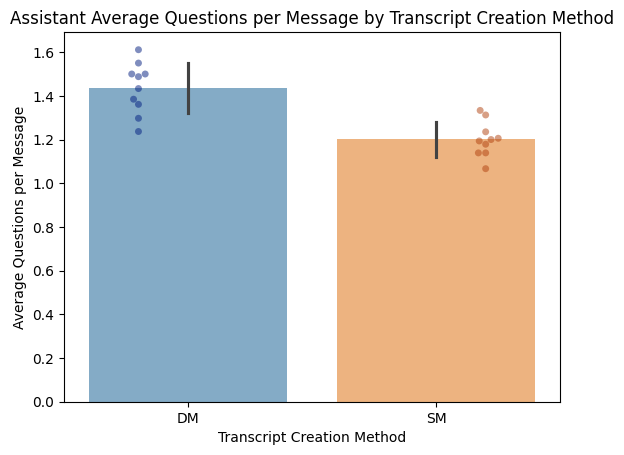

In [338]:
g = barplot_data(gpt_ldf, x_axis="gentype", y_axis='asst_avg_qs_per_msg', x_axis_label="Transcript Creation Method", y_axis_label="Average Questions per Message")
plt.title("Assistant Average Questions per Message by Transcript Creation Method")

In [463]:
describe_these_variables(gpt_ldf, ['asst_avg_qs_per_msg'], "gentype")

,asst_avg_qs_per_msg_DM,asst_avg_qs_per_msg_SM
count,10.000000,10.000000
mean,1.436212,1.200357
std,0.116282,0.079903
min,1.236842,1.066667
25%,1.366987,1.148810
50%,1.460569,1.196774
75%,1.500000,1.227941
max,1.611111,1.333333


In [464]:
get_pvalues(
    gpt_ldf, 
    col="asst_avg_qs_per_msg", 
    x_val="gentype",
    bf_correction=True) 

[(('DM', 'SM'), 5.0172227577630027e-05, '***')]

### empathy statements..?

In [451]:
gpt_ldf['empathy_scaled'] = gpt_ldf["asst_empathy_statements"]/(gpt_ldf["asst_empathy_statements"]+gpt_ldf["asst_other_statements"]+gpt_ldf["asst_indepth_qs"]+gpt_ldf["asst_opening_qs"])

Text(0.5, 1.0, 'Assistant Empathy Statements by Transcript Creation Method')

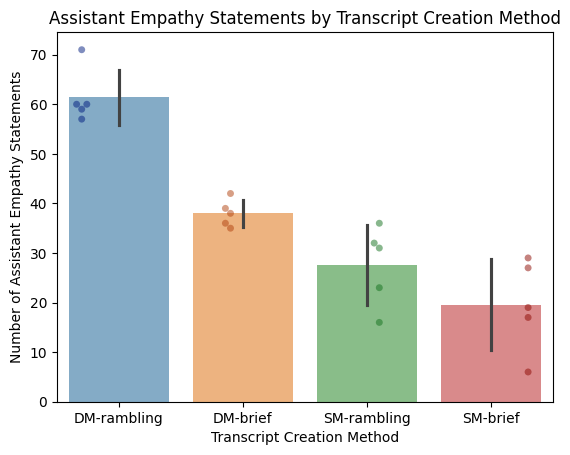

In [183]:
g = barplot_data(gpt_ldf, x_axis="dataset", y_axis='asst_empathy_statements', x_axis_label="Transcript Creation Method", y_axis_label="Number of Assistant Empathy Statements")
plt.title("Assistant Empathy Statements by Transcript Creation Method")

In [182]:
describe_these_variables(gpt_ldf, ['asst_empathy_statements'])

,asst_empathy_statements_DM-rambling,asst_empathy_statements_DM-brief,asst_empathy_statements_SM-rambling,asst_empathy_statements_SM-brief
count,5.000000,5.000000,5.000000,5.000000
mean,61.400000,38.000000,27.600000,19.600000
std,5.504544,2.738613,8.018728,9.154234
min,57.000000,35.000000,16.000000,6.000000
25%,59.000000,36.000000,23.000000,17.000000
50%,60.000000,38.000000,31.000000,19.000000
75%,60.000000,39.000000,32.000000,27.000000
max,71.000000,42.000000,36.000000,29.000000


In [441]:
get_pvalues(
    gpt_ldf, 
    col="asst_empathy_statements", 
    bf_correction=True) 

[(('DM-rambling', 'DM-brief'), 4.139111724317396e-05, '***'),
 (('DM-rambling', 'SM-rambling'), 7.131929387994944e-05, '**'),
 (('DM-rambling', 'SM-brief'), 4.824290378243696e-05, '***'),
 (('DM-brief', 'SM-rambling'), 0.02806459730679186, 'ns'),
 (('DM-brief', 'SM-brief'), 0.005018269790601676, 'ns'),
 (('SM-rambling', 'SM-brief'), 0.22619605222042824, 'ns')]

Text(0.5, 1.0, 'Assistant Empathy Statements Ratio by Transcript Creation Method')

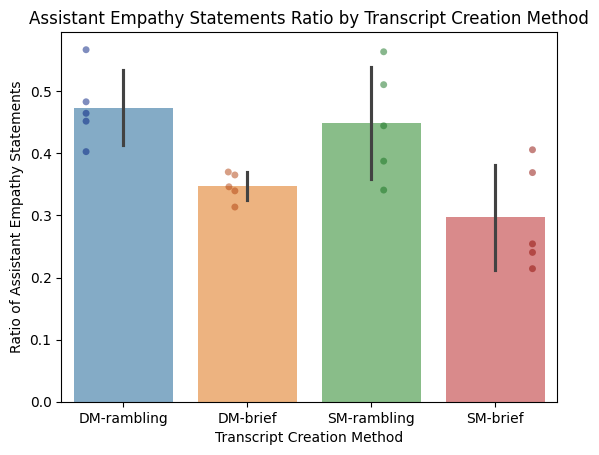

In [452]:
g = barplot_data(gpt_ldf, x_axis="dataset", y_axis='empathy_scaled', x_axis_label="Transcript Creation Method", y_axis_label="Ratio of Assistant Empathy Statements")
plt.title("Assistant Empathy Statements Ratio by Transcript Creation Method")

In [454]:
describe_these_variables(gpt_ldf, ['empathy_scaled'])

,empathy_scaled_DM-rambling,empathy_scaled_DM-brief,empathy_scaled_SM-rambling,empathy_scaled_SM-brief
count,5.000000,5.000000,5.000000,5.000000
mean,0.473835,0.346911,0.449426,0.296775
std,0.059937,0.022551,0.090037,0.084984
min,0.402778,0.313559,0.340909,0.214286
25%,0.451852,0.339623,0.387500,0.240506
50%,0.464567,0.346154,0.444444,0.254237
75%,0.483051,0.365217,0.510638,0.369048
max,0.566929,0.370000,0.563636,0.405797


In [439]:
get_pvalues(
    gpt_ldf, 
    col="asst_empathy_statements", 
    bf_correction=True)

[(('DM-rambling', 'DM-brief'), 4.139111724317396e-05, '***'),
 (('DM-rambling', 'SM-rambling'), 7.131929387994944e-05, '**'),
 (('DM-rambling', 'SM-brief'), 4.824290378243696e-05, '***'),
 (('DM-brief', 'SM-rambling'), 0.02806459730679186, 'ns'),
 (('DM-brief', 'SM-brief'), 0.005018269790601676, 'ns'),
 (('SM-rambling', 'SM-brief'), 0.22619605222042824, 'ns')]

Text(0.5, 1.0, 'Assistant Empathy Statements by Transcript Creation Method')

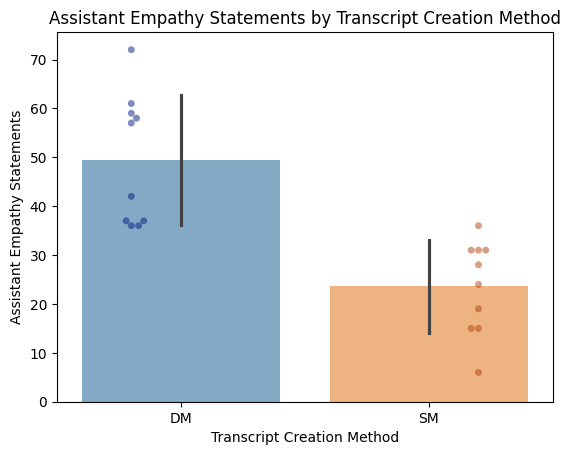

In [461]:
g = barplot_data(gpt_ldf, x_axis="gentype", y_axis='asst_empathy_statements', x_axis_label="Transcript Creation Method", y_axis_label="Assistant Empathy Statements")
plt.title("Assistant Empathy Statements by Transcript Creation Method")

In [456]:
describe_these_variables(gpt_ldf, ['asst_empathy_statements'], "gentype")

,asst_empathy_statements_DM,asst_empathy_statements_SM
count,10.000000,10.000000
mean,49.500000,23.600000
std,13.293691,9.524238
min,36.000000,6.000000
25%,37.000000,16.000000
50%,49.500000,26.000000
75%,58.750000,31.000000
max,72.000000,36.000000


In [457]:
get_pvalues(
    gpt_ldf, 
    col="asst_empathy_statements", 
    x_val="gentype",
    bf_correction=True) 

[(('DM', 'SM'), 9.118510767528308e-05, '***')]

Text(0.5, 1.0, 'Assistant Empathy Statements Ratio by Transcript Creation Method')

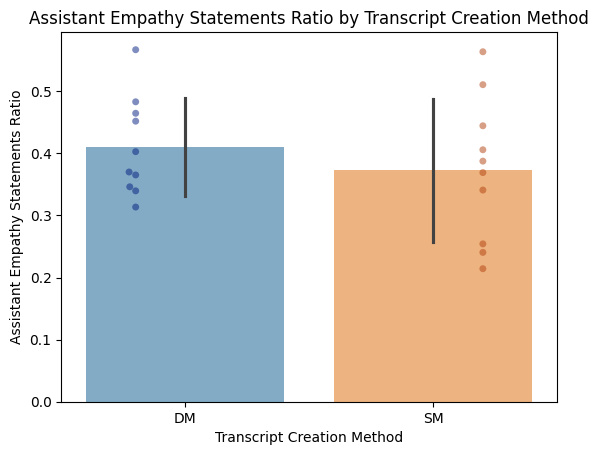

In [462]:
g = barplot_data(gpt_ldf, x_axis="gentype", y_axis='empathy_scaled', x_axis_label="Transcript Creation Method", y_axis_label="Assistant Empathy Statements Ratio")
plt.title("Assistant Empathy Statements Ratio by Transcript Creation Method")

In [459]:
describe_these_variables(gpt_ldf, ['empathy_scaled'], "gentype")

,empathy_scaled_DM,empathy_scaled_SM
count,10.000000,10.000000
mean,0.410373,0.373100
std,0.079358,0.115264
min,0.313559,0.214286
25%,0.350920,0.275905
50%,0.386389,0.378274
75%,0.461388,0.434783
max,0.566929,0.563636


In [446]:
get_pvalues(
    gpt_ldf, 
    col="empathy_scaled", 
    x_val="gentype",
    bf_correction=True) 

[(('DM', 'SM'), 0.17965740339694802, 'ns')]

### edge case adherence

In [134]:
def get_edge_case_bool(string):
    if "True" in string.split("Final Answer: ")[-1]:
        return True
    else:
        return False

def label_edge_case_bool(bool_prompt, bool_result):
    bool_prompt = bool(bool_prompt)
    bool_result = bool(bool_result)

    if bool_prompt == bool_result:
        match= "hit"
    elif (bool_prompt==True) & (bool_result==False): #false negative: type 2
        match= "false negative"
    elif (bool_prompt==False) & (bool_result==True): #false positive: type 1
        match= "false positive"
    else:
        match=""
    return match

def label_row(row):
   pass

In [135]:
gpt_ldf["initial_edge_case"] = ~gpt_ldf["edge_case"].isnull() #get initial state

gpt_ldf["user_edge_case"] = gpt_ldf["'user_edge_case_present'"].apply(get_edge_case_bool) #patient behavior
gpt_ldf["asst_edge_case"] = gpt_ldf["'asst_edge_case_present'"].apply(get_edge_case_bool) #assistant behavior

In [136]:
gpt_ldf["user_edge_case_followed"] = gpt_ldf.apply(lambda x: label_edge_case_bool(x["initial_edge_case"], x["user_edge_case"]),axis=1).astype("category")
gpt_ldf["asst_edge_case_followed"] = gpt_ldf.apply(lambda x: label_edge_case_bool(x["initial_edge_case"], x["asst_edge_case"]),axis=1).astype("category")

In [137]:
gpt_ldf[["filename","edge_case","initial_edge_case","asst_edge_case","asst_edge_case_followed",]]

,filename,edge_case,initial_edge_case,asst_edge_case,asst_edge_case_followed
1,DM_20240428-223120_Interview.json,"Upon first asking about medication, please mis...",True,True,hit
2,DM_20240428-220138_Interview.json,NaN,False,False,hit
3,DM_20240428-222702_Interview.json,"Upon first asking about medication, please mis...",True,False,false negative
4,DM_20240428-215539_Interview.json,NaN,False,False,hit
5,DM_20240428-221850_Interview.json,"Upon first asking about medication, please mis...",True,False,false negative
0,DM_20240428-221529_Interview.json,"Upon first asking about medication, please mis...",True,True,hit
6,DM_20240428-222418_Interview.json,"Upon first asking about medication, please mis...",True,False,false negative
7,DM_20240428-221238_Interview.json,NaN,False,False,hit
8,DM_20240428-220641_Interview.json,NaN,False,False,hit
9,DM_20240428-220920_Interview.json,NaN,False,False,hit


In [138]:
gpt_ldf["user_edge_case_followed"].value_counts()

user_edge_case_followed
hit    20
Name: count, dtype: int64

In [139]:
edge_case_df = get_melted_df(gpt_ldf, ["dataset", "gentype","bar_col"], {"asst_edge_case_followed":"assistant","user_edge_case_followed":"patient"},"role","edge_case_coverage")
edge_case_df['edge_case_coverage'] = edge_case_df['edge_case_coverage'].astype("category")

['asst_edge_case_followed', 'user_edge_case_followed']


In [51]:
# edge_case_df

In [140]:
edge_case_desc_df_p = describe_these_variables(edge_case_df[edge_case_df["role"]=="patient"], ["edge_case_coverage"], "dataset")
edge_case_desc_df_p = edge_case_desc_df_p.loc[(edge_case_desc_df_p!=0).any(axis=1)] #drop any rows of 0s
old_index = edge_case_desc_df_p.index.values
# print({f"{i}": f"assistant {i}" for i in old_index})
edge_case_desc_df_p = edge_case_desc_df_p.rename(index={f"{i}": f"patient {i}" for i in old_index})
edge_case_desc_df_p

,edge_case_coverage_DM-rambling,edge_case_coverage_DM-brief,edge_case_coverage_SM-rambling,edge_case_coverage_SM-brief
patient hit,5,5,5,5


In [141]:
edge_case_desc_df_a = describe_these_variables(edge_case_df[edge_case_df["role"]=="assistant"], ["edge_case_coverage"], "dataset")
edge_case_desc_df_a = edge_case_desc_df_a.loc[(edge_case_desc_df_a!=0).any(axis=1)] #drop any rows of 0s
old_index = edge_case_desc_df_a.index.values
# print({f"{i}": f"assistant {i}" for i in old_index})
edge_case_desc_df_a = edge_case_desc_df_a.rename(index={f"{i}": f"assistant {i}" for i in old_index})
edge_case_desc_df_a

,edge_case_coverage_DM-rambling,edge_case_coverage_DM-brief,edge_case_coverage_SM-rambling,edge_case_coverage_SM-brief
assistant hit,3,4,4,4
assistant false negative,2,1,1,1


In [142]:
edge_case_desc_df = pd.concat([edge_case_desc_df_p,edge_case_desc_df_a])
edge_case_desc_df
# edge_case_desc_df.index.rename([])

,edge_case_coverage_DM-rambling,edge_case_coverage_DM-brief,edge_case_coverage_SM-rambling,edge_case_coverage_SM-brief
patient hit,5,5,5,5
assistant hit,3,4,4,4
assistant false negative,2,1,1,1


In [143]:
#set up a dictionary to turn into a pi chart
dfs=edge_case_df["dataset"].unique()

categories = edge_case_desc_df.index.to_list()
empty_labels = [""]*len(categories)
# labels_renamed=["Hit", "Type 2 Error", "Type 1 Error"]

edge_case_desc_df = edge_case_desc_df.rename(columns={col:str(col.split("_")[-1]) for col in edge_case_desc_df.columns})

stype_dict = edge_case_desc_df.to_dict()
for k in stype_dict.keys():
    stype_dict[k] = [v for k, v in stype_dict[k].items()]
stype_dict

{'DM-rambling': [5, 3, 2],
 'DM-brief': [5, 4, 1],
 'SM-rambling': [5, 4, 1],
 'SM-brief': [5, 4, 1]}

In [68]:
sns.color_palette("Paired", 8)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0)]

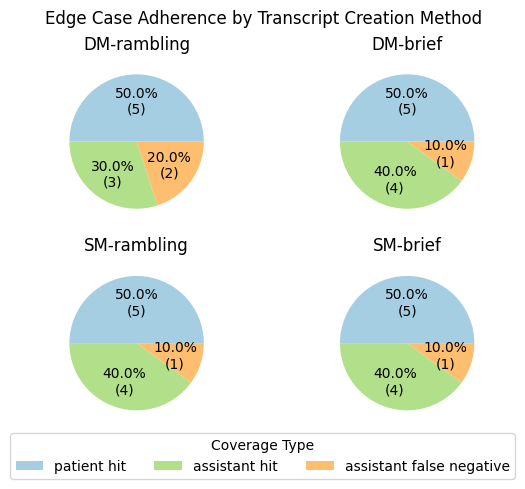

In [144]:
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

colors = [
    sns.color_palette("Paired", 8)[0],
    sns.color_palette("Paired", 8)[2],
    sns.color_palette("Paired", 8)[6],
    sns.color_palette("Paired", 8)[4],
    ]

fig, axs = plt.subplots(nrows=2, ncols=2)
fig.suptitle("Edge Case Adherence by Transcript Creation Method")

axs[0,0].pie(x=stype_dict["DM-rambling"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["DM-rambling"]), colors=colors)
axs[0,0].set_title("DM-rambling")

axs[0,1].pie(x=stype_dict["DM-brief"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["DM-brief"]), colors=colors)
axs[0,1].set_title("DM-brief")

axs[1,0].pie(x=stype_dict["SM-rambling"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["SM-rambling"]), colors=colors)
axs[1,0].set_title("SM-rambling")

wedges, texts, autotexts = axs[1,1].pie(x=stype_dict["SM-brief"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["SM-brief"]), colors=colors)
axs[1,1].set_title("SM-brief")

# axs[0,1].legend(wedges, edge_case_desc_df.index.values, title="Coverage Type",loc="center left",
#     bbox_to_anchor=(1, 0, 0.5, 0))
axs[1,0].legend(wedges, edge_case_desc_df.index.values, title="Coverage Type", loc = "lower center", bbox_to_anchor=(1, -0.35, 0.5, 0), ncol=4)

In [75]:
edge_case_desc_df1 = describe_these_variables(edge_case_df, ["edge_case_coverage"], "gentype")
edge_case_desc_df1

#set up a dictionary to turn into a pi chart
dfs=edge_case_df["gentype"].unique()

categories = edge_case_desc_df1.index.to_list()
empty_labels = [""]*len(categories)

edge_case_desc_df1 = edge_case_desc_df1.rename(columns={col:str(col.split("_")[-1]) for col in edge_case_desc_df1.columns})

stype_dict = edge_case_desc_df1.to_dict()
for k in stype_dict.keys():
    stype_dict[k] = [v for k, v in stype_dict[k].items()]
stype_dict

{'DM': [17, 3], 'SM': [18, 2]}

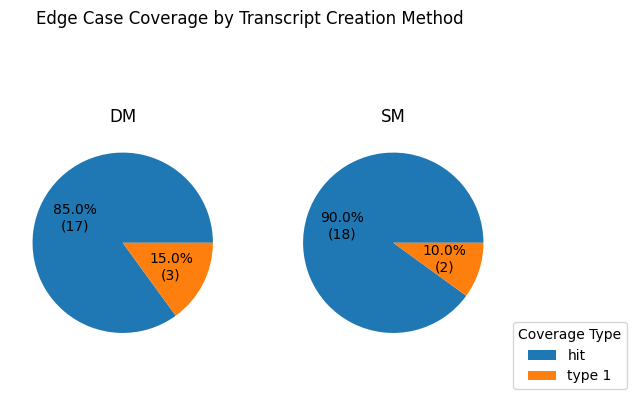

In [76]:
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

fig, axs = plt.subplots(ncols=2)
fig.suptitle("Edge Case Coverage by Transcript Creation Method")

axs[0].pie(x=stype_dict["DM"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["DM"]))
axs[0].set_title("DM")

axs[1].pie(x=stype_dict["SM"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["SM"]))
axs[1].set_title("SM")


axs[1].legend(wedges, edge_case_desc_df1.index.values, title="Coverage Type",loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 0))

### pi chart of type of questions asked

In [126]:
#data should be by transcript creation method
#labels should be the type of question
stype_df = describe_these_variables(gpt_ldf,['asst_opening_qs','asst_indepth_qs', 'asst_empathy_statements','asst_other_statements'])
stype_df

,asst_opening_qs_DM-rambling,asst_opening_qs_DM-brief,asst_opening_qs_SM-rambling,asst_opening_qs_SM-brief,asst_indepth_qs_DM-rambling,asst_indepth_qs_DM-brief,asst_indepth_qs_SM-rambling,asst_indepth_qs_SM-brief,asst_empathy_statements_DM-rambling,asst_empathy_statements_DM-brief,asst_empathy_statements_SM-rambling,asst_empathy_statements_SM-brief,asst_other_statements_DM-rambling,asst_other_statements_DM-brief,asst_other_statements_SM-rambling,asst_other_statements_SM-brief
count,5.00000,5.000000,5.000000,5.000000,5.000000,5.00000,5.0000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,22.40000,21.400000,13.000000,14.200000,29.800000,31.20000,14.6000,18.400000,61.400000,37.60000,27.400000,19.800000,16.600000,18.400000,6.400000,11.400000
std,4.27785,1.341641,4.301163,4.207137,3.962323,5.80517,6.8775,6.542171,6.107373,2.50998,8.142481,10.084642,5.128353,1.341641,2.302173,4.827007
min,19.00000,20.000000,7.000000,9.000000,24.000000,24.00000,8.0000,7.000000,57.000000,36.00000,15.000000,6.000000,12.000000,16.000000,3.000000,6.000000
25%,19.00000,20.000000,11.000000,12.000000,29.000000,29.00000,10.0000,19.000000,58.000000,36.00000,24.000000,15.000000,13.000000,19.000000,5.000000,9.000000
50%,20.00000,22.000000,13.000000,13.000000,30.000000,31.00000,11.0000,21.000000,59.000000,37.00000,31.000000,19.000000,16.000000,19.000000,8.000000,11.000000
75%,26.00000,22.000000,16.000000,18.000000,31.000000,32.00000,21.0000,22.000000,61.000000,37.00000,31.000000,28.000000,17.000000,19.000000,8.000000,12.000000
max,28.00000,23.000000,18.000000,19.000000,35.000000,40.00000,23.0000,23.000000,72.000000,42.00000,36.000000,31.000000,25.000000,19.000000,8.000000,19.000000


In [127]:
dfs=["DM-rambling","DM-brief","SM-rambling","SM-brief"]
labels=["asst_opening_qs", "asst_indepth_qs", "asst_empathy_statements", "asst_other_statements"]
empty_labels = [""]*len(labels)
labels_renamed=["Opening Questions", "In-Depth Questions", "Empathy Statements", "Other"]

stype_dict = {}
# df_label="DM-rambling"
for df_label in dfs:
    stype_dict[df_label]=[stype_df[f"{label}_{df_label}"]["mean"] for label in labels]
print(stype_dict)

{'DM-rambling': [22.4, 29.8, 61.4, 16.6], 'DM-brief': [21.4, 31.2, 37.6, 18.4], 'SM-rambling': [13.0, 14.6, 27.4, 6.4], 'SM-brief': [14.2, 18.4, 19.8, 11.4]}


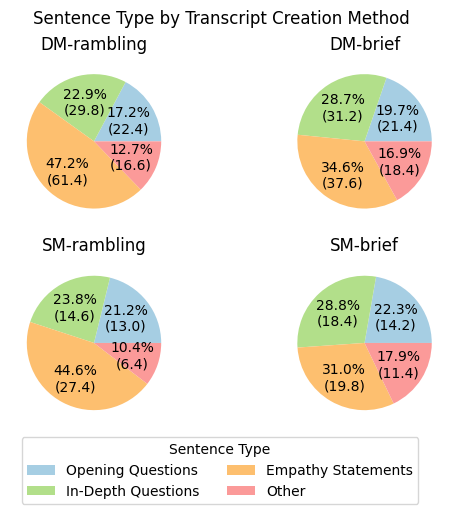

In [133]:
def func(pct, allvals):
    # absolute = int(np.round(pct/100.*np.sum(allvals)))
    absolute = pct/100.*np.sum(allvals)
    return f"{pct:.1f}%\n({absolute:.1f})"

fig, axs = plt.subplots(nrows=2, ncols=2)
fig.suptitle("Sentence Type by Transcript Creation Method")

axs[0,0].pie(x=stype_dict["DM-rambling"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["DM-rambling"]), colors=colors)
axs[0,0].set_title("DM-rambling")

axs[0,1].pie(x=stype_dict["DM-brief"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["DM-brief"]),colors=colors)
axs[0,1].set_title("DM-brief")

axs[1,0].pie(x=stype_dict["SM-rambling"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["SM-rambling"]), colors=colors)
axs[1,0].set_title("SM-rambling")

wedges, texts, autotexts = axs[1,1].pie(x=stype_dict["SM-brief"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["SM-brief"]), colors=colors)
axs[1,1].set_title("SM-brief")

# axs[0,0].pie(x=stype_dict["DM-rambling"], labels=empty_labels,autopct='%1.1f%%')
# axs[0,0].set_title("DM-rambling")

# axs[0,1].pie(x=stype_dict["DM-brief"], labels=empty_labels,autopct='%1.1f%%')
# axs[0,1].set_title("DM-brief")

# axs[1,0].pie(x=stype_dict["SM-rambling"], labels=empty_labels,autopct='%1.1f%%')
# axs[1,0].set_title("SM-rambling")

# wedges, texts, autotexts = axs[1,1].pie(x=stype_dict["SM-brief"], labels=empty_labels,autopct='%1.1f%%')
# axs[1,1].set_title("SM-brief")

# axs[0,1].legend(wedges, labels_renamed, title="Sentence Type",loc="center left",
#           bbox_to_anchor=(1, 0, 0.5, 0))

axs[1,0].legend(wedges, labels_renamed, title="Sentence Type", loc = "lower center", bbox_to_anchor=(1, -0.5, 0.5, 0), ncol=2)

Text(0.5, 1.0, 'Question Bank\nquestions')

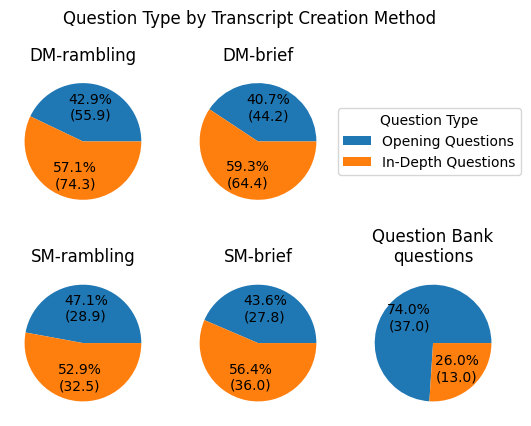

In [87]:
#assign data
dfs=["DM-rambling","DM-brief","SM-rambling","SM-brief"]
labels=["asst_opening_qs", "asst_indepth_qs"]
empty_labels = ['','']
labels_renamed=["Opening Questions", "In-Depth Questions"]

qtype_dict = {}
# df_label="DM-rambling"
for df_label in dfs:
    qtype_dict[df_label]=[stype_df[f"{label}_{df_label}"]["mean"] for label in labels]
# print(qtype_dict)

fig, axs = plt.subplots(nrows=2, ncols=3)
axs[0,0].pie(x=qtype_dict["DM-rambling"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["DM-rambling"]))
axs[0,0].set_title("DM-rambling")

fig.suptitle("Question Type by Transcript Creation Method")

axs[0,1].pie(x=qtype_dict["DM-brief"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["DM-brief"]))
axs[0,1].set_title("DM-brief")

axs[1,0].pie(x=qtype_dict["SM-rambling"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["SM-rambling"]))
axs[1,0].set_title("SM-rambling")

wedges, texts, autotexts = axs[1,1].pie(x=qtype_dict["SM-brief"], labels=empty_labels,autopct=lambda pct: func(pct, stype_dict["SM-brief"]))
axs[1,1].set_title("SM-brief")

axs[0,1].legend(wedges, labels_renamed, title="Question Type",loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

axs[0,2].axis('off')

axs[1,2].pie(x=[qb_num_opening_qs,qb_num_idqs], labels=['',''],autopct=lambda pct: func(pct, [qb_num_opening_qs,qb_num_idqs]))
axs[1,2].set_title("Question Bank\nquestions")